## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('../H2/AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [3]:
df.price

0        149
1        225
2        150
3         89
4         80
        ... 
48890     70
48891     40
48892    115
48893     55
48894     90
Name: price, Length: 48895, dtype: int64

* Apply the log tranform to `price` (WHY???)
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)
#drop the price column before doing anything
del df_train['price']
del df_val['price']
del df_test['price']


In [5]:
y_train

array([4.7095302 , 4.26267988, 6.13339804, ..., 3.93182563, 5.52545294,
       5.39362755])

In [6]:
#It will fail with the float numbers above. I need to use a label encoder, since this
# is a classifier problem
#  LabelEncoder will convert string or float values to 0 .. n classes.
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)

In [7]:
y_train_encoded

array([ 98,  58, 403, ...,  38, 238, 207])

Now, use `DictVectorizer` to turn train and validation into matrices:

In [8]:
from sklearn.feature_extraction import DictVectorizer
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train_encoded)
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- class: 38
|--- room_type=Entire home/apt >  0.50
|   |--- class: 138



Which feature is used for splitting the data?

* `room_type` THIS ONE
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(random_state = 1,n_estimators=10,n_jobs=-1)

# fit your model
rf_model.fit(X_train, y_train)

# Calculate the mean absolute error of your Random Forest model on the validation data
rf_preds = rf_model.predict(X_val)
rf_val_mae = np.sqrt(mean_squared_error(y_val,rf_preds))

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))


Validation MAE for Random Forest Model: 0.4598535778342608


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459 THIS ONE??
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120 THIS ONE

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [12]:
nest = np.arange(10,200,10)

for max_depth in [10, 15, 20, 25]:
    for n in nest:
        rf_model = RandomForestRegressor(random_state = 1,n_estimators=n,n_jobs=-1,max_depth=max_depth)
        rf_model.fit(X_train, y_train)
        rf_preds = rf_model.predict(X_val)
        rf_val_rmse = np.sqrt(mean_squared_error(y_val,rf_preds))
        print(f"Validation RMSE with {n} estimators and max_depth {max_depth}: {rf_val_rmse}")

Validation RMSE with 10 estimators and max_depth 10: 0.445596171749275
Validation RMSE with 20 estimators and max_depth 10: 0.44203282715576686
Validation RMSE with 30 estimators and max_depth 10: 0.4413920618234788
Validation RMSE with 40 estimators and max_depth 10: 0.4415405361267545
Validation RMSE with 50 estimators and max_depth 10: 0.44112040608323544
Validation RMSE with 60 estimators and max_depth 10: 0.4410956757983925
Validation RMSE with 70 estimators and max_depth 10: 0.4408047570608675
Validation RMSE with 80 estimators and max_depth 10: 0.44063392403596924
Validation RMSE with 90 estimators and max_depth 10: 0.44036005791386457
Validation RMSE with 100 estimators and max_depth 10: 0.44014389763440204
Validation RMSE with 110 estimators and max_depth 10: 0.44005376814946023
Validation RMSE with 120 estimators and max_depth 10: 0.4398402482041807
Validation RMSE with 130 estimators and max_depth 10: 0.43987437072357427
Validation RMSE with 140 estimators and max_depth 10: 

What's the best `max_depth`:

* 10 PROB THIS
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [11]:
rf_model = RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [12]:
rf_model.feature_importances_

array([7.65657560e-02, 3.02638819e-02, 1.51755500e-01, 1.53475601e-01,
       5.31695975e-02, 4.47273475e-04, 1.11450114e-03, 3.40436593e-02,
       1.03414350e-03, 8.37127171e-05, 4.25185232e-02, 5.45945765e-02,
       3.91898023e-01, 4.87707077e-03, 4.15817992e-03])

<BarContainer object of 15 artists>

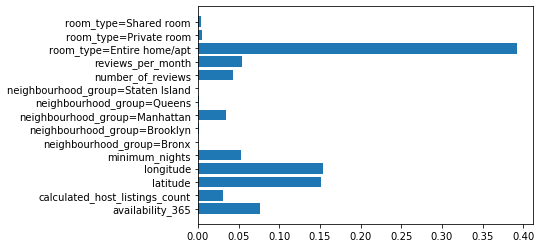

In [13]:
plt.barh(dv.get_feature_names(), rf_model.feature_importances_)


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	 THIS ONE
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [14]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
import xgboost as xgb
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:3.02752	val-rmse:3.02415
[5]	train-rmse:0.67490	val-rmse:0.67752
[10]	train-rmse:0.43912	val-rmse:0.44981
[15]	train-rmse:0.42259	val-rmse:0.43827
[20]	train-rmse:0.41716	val-rmse:0.43691
[25]	train-rmse:0.41365	val-rmse:0.43621
[30]	train-rmse:0.40712	val-rmse:0.43543
[35]	train-rmse:0.40444	val-rmse:0.43510
[40]	train-rmse:0.40103	val-rmse:0.43466
[45]	train-rmse:0.39723	val-rmse:0.43371
[50]	train-rmse:0.39446	val-rmse:0.43384
[55]	train-rmse:0.39129	val-rmse:0.43378
[60]	train-rmse:0.38743	val-rmse:0.43404
[65]	train-rmse:0.38421	val-rmse:0.43450
[70]	train-rmse:0.38117	val-rmse:0.43467
[75]	train-rmse:0.37801	val-rmse:0.43489
[80]	train-rmse:0.37668	val-rmse:0.43526
[85]	train-rmse:0.37259	val-rmse:0.43537
[90]	train-rmse:0.36998	val-rmse:0.43539
[95]	train-rmse:0.36742	val-rmse:0.43579
[99]	train-rmse:0.36478	val-rmse:0.43621


Now change `eta` first to `0.1` and then to `0.01`

In [15]:
xgb_params['eta'] = 0.1 
  
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:3.87217	val-rmse:3.86889
[5]	train-rmse:2.31905	val-rmse:2.31692
[10]	train-rmse:1.41910	val-rmse:1.41786
[15]	train-rmse:0.91299	val-rmse:0.91348
[20]	train-rmse:0.64528	val-rmse:0.64883
[25]	train-rmse:0.51733	val-rmse:0.52364
[30]	train-rmse:0.46186	val-rmse:0.47101
[35]	train-rmse:0.43843	val-rmse:0.44997
[40]	train-rmse:0.42770	val-rmse:0.44150
[45]	train-rmse:0.42222	val-rmse:0.43795
[50]	train-rmse:0.41868	val-rmse:0.43589
[55]	train-rmse:0.41644	val-rmse:0.43515
[60]	train-rmse:0.41432	val-rmse:0.43460
[65]	train-rmse:0.41226	val-rmse:0.43400
[70]	train-rmse:0.41059	val-rmse:0.43361
[75]	train-rmse:0.40876	val-rmse:0.43336
[80]	train-rmse:0.40747	val-rmse:0.43306
[85]	train-rmse:0.40626	val-rmse:0.43299
[90]	train-rmse:0.40478	val-rmse:0.43280
[95]	train-rmse:0.40406	val-rmse:0.43272
[99]	train-rmse:0.40277	val-rmse:0.43250


In [16]:
xgb_params['eta'] = 0.01 
  
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:4.25336	val-rmse:4.25010
[5]	train-rmse:4.04779	val-rmse:4.04454
[10]	train-rmse:3.85242	val-rmse:3.84921
[15]	train-rmse:3.66674	val-rmse:3.66359
[20]	train-rmse:3.49030	val-rmse:3.48719
[25]	train-rmse:3.32263	val-rmse:3.31956
[30]	train-rmse:3.16332	val-rmse:3.16029
[35]	train-rmse:3.01196	val-rmse:3.00898
[40]	train-rmse:2.86817	val-rmse:2.86533
[45]	train-rmse:2.73158	val-rmse:2.72884
[50]	train-rmse:2.60185	val-rmse:2.59925
[55]	train-rmse:2.47865	val-rmse:2.47612
[60]	train-rmse:2.36167	val-rmse:2.35927
[65]	train-rmse:2.25061	val-rmse:2.24835
[70]	train-rmse:2.14519	val-rmse:2.14303
[75]	train-rmse:2.04514	val-rmse:2.04311
[80]	train-rmse:1.95022	val-rmse:1.94827
[85]	train-rmse:1.86015	val-rmse:1.85833
[90]	train-rmse:1.77472	val-rmse:1.77302
[95]	train-rmse:1.69373	val-rmse:1.69214
[99]	train-rmse:1.63198	val-rmse:1.63045


What's the best eta?

* 0.3 THIS ONE
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

